In [ ]:
# An RNN for time series data
# source
# https://datahacker.rs/011-pytorch-rnn-with-pytorch/
# Jan 2022

In [1]:
import os, sys

from google.colab import drive
drive.mount('/content/drive')
#change this based on your setup
root = '/content/drive/MyDrive/ART/machinelearning/'

Mounted at /content/drive


In [2]:
import torch 
import torch.nn as nn
import numpy
#import pandas
import matplotlib.pyplot as plt

In [6]:
# Create sample time series data (sine wave)
x = torch.linspace(0,799, 800)
y = torch.sin(x * 2 * numpy.pi / 40)

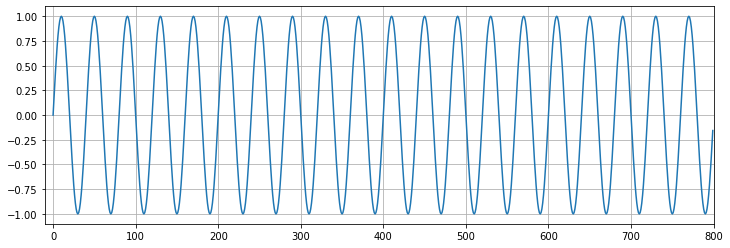

In [7]:
plt.figure(figsize = (12,4))
plt.xlim(-10, 801)
plt.grid(True)
plt.plot(y.numpy() )
plt.show()

In [8]:
# Create some test and training data
test_size = 40
train_set = y[:-test_size]
test_set = y[-test_size:]

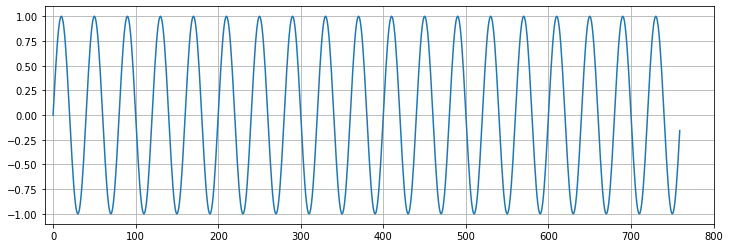

In [9]:
# Check the training set - missing the last 40 items
plt.figure(figsize = (12,4))
plt.xlim(-10, 801)
plt.grid(True)
plt.plot(train_set.numpy())
plt.show()

In [3]:
# Define the input data
def input_data(seq, ws):
  output = []   
  L = len(seq)
  for i in range((L) - ws):
    window = seq[i:i+ws]
    label = seq[i+ws:i+ws+1]
    #print(i)
    output.append((window, label))
 
  return (output)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  after removing the cwd from sys.path.


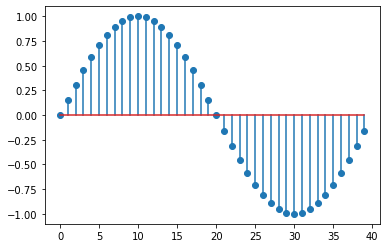

In [10]:
# View that data seperately
window_size = 40
train_data = input_data(train_set, window_size)
plt.stem(train_data[0][0])
plt.show()

In [11]:
# Create an RNN (LSTM) model with a class
class myLSTM(nn.Module):
  def __init__(self, input_size=1, hidden_size=50, out_size=1):
    super().__init__()
    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(input_size, hidden_size )
    self.linear = nn.Linear(hidden_size, out_size)
    self.hidden = (torch.zeros(1,1,hidden_size ), torch.zeros(1,1,hidden_size))
 
  def forward(self, seq):
    lstm_out, self.hidden = self.lstm(seq.view(len(seq),1,-1 ), self.hidden)
    pred = self.linear(lstm_out.view(len(seq) ,-1 ))  
    return (pred[-1])

In [12]:
# Instantiate the model
model = myLSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
print(model)

myLSTM(
  (lstm): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)


In [13]:
# Find number of elements
for p in model.parameters():
  print(p.numel())

200
10000
200
200
50
1


In [16]:
# Training loop
epochs = 20
future = 40
for i in range(epochs):
  for seq, y_train in train_data:
    optimizer.zero_grad()
    model.hidden = (torch.zeros(1,1,model.hidden_size),torch.zeros(1,1,model.hidden_size))
    
    y_pred = model(seq)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
 
  print(f"Epoch {i} Loss {loss.item()} ")
  preds = train_set[-window_size:].tolist()
 
  for f in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
      model.hidden = (torch.zeros(1,1,model.hidden_size),torch.zeros(1,1,model.hidden_size))
      preds.append(model(seq).item())
 
  loss = criterion(torch.tensor(preds[-window_size :]), y[760:] )
  print(f'Performance (loss) on test range: {loss}')

Epoch 0 Loss 4.719221396953799e-05 
Performance (loss) on test range: 0.002999021438881755
Epoch 1 Loss 4.524885298451409e-05 
Performance (loss) on test range: 0.002962499624118209
Epoch 2 Loss 4.339444058132358e-05 
Performance (loss) on test range: 0.0029209416825324297
Epoch 3 Loss 4.1611310734879225e-05 
Performance (loss) on test range: 0.002875580219551921
Epoch 4 Loss 3.9895887312013656e-05 
Performance (loss) on test range: 0.002827954012900591
Epoch 5 Loss 3.82431062462274e-05 
Performance (loss) on test range: 0.0027789180167019367
Epoch 6 Loss 3.6650002584792674e-05 
Performance (loss) on test range: 0.00272919749841094
Epoch 7 Loss 3.511656905175187e-05 
Performance (loss) on test range: 0.0026795112062245607
Epoch 8 Loss 3.3639757020864636e-05 
Performance (loss) on test range: 0.002630139235407114
Epoch 9 Loss 3.222105078748427e-05 
Performance (loss) on test range: 0.00258138170465827
Epoch 10 Loss 3.085757271037437e-05 
Performance (loss) on test range: 0.0025335703976

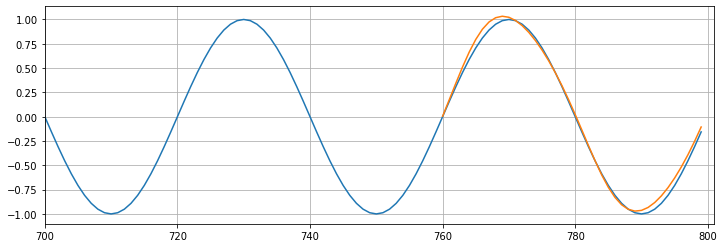

In [17]:
#Show the predicted values compared to the original (removed) data elements
plt.figure(figsize=(12,4))
plt.xlim(700, 801)
plt.grid(True)
plt.plot(y.numpy())
plt.plot(range(760,800), preds[window_size:])
plt.show()

In [18]:
# Get only the predicted future values and add to a list
preds = y[-window_size:].tolist()
for i in range(future):
  seq = torch.FloatTensor(preds[-window_size:])
  with torch.no_grad():
    model.hidden = (torch.zeros(1,1,model.hidden_size), torch.zeros(1,1,model.hidden_size))
    preds.append(model(seq).item())

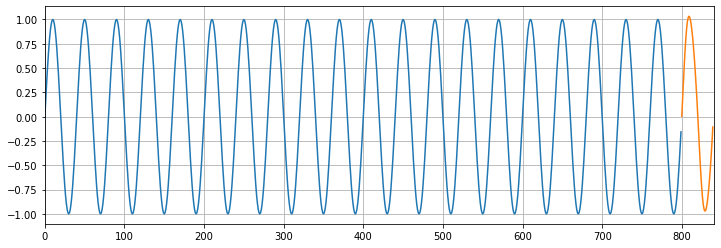

In [19]:
# Show the old and new predicted values on one time line
plt.figure(figsize = (12,4))
plt.xlim(0,841)
plt.grid(True)
plt.plot(y.numpy())
plt.plot(range(800, 800+future), preds[window_size:])
plt.show()